Plot Fig. 3a,b

In [1]:
import sys
import os
import argparse
import pickle
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.patches import Circle

from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.SM_contrast.b3_make_multi_lvl_var_field_anomaly_contrast import load_multi_lvl_var_contrast_composite_mean_ano_field
from CP4.make_composites.SM_contrast.significance.b3_compute_multi_level_var_field_significance_contrast_merge import load_multi_lvl_var_contrast_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
coords = [[(10., 18.), (-20., -10.)], [(10.,18.), (-14., -4.)], [(10.,18.), (-8., 2.)], [(10.,18.), (-2.,8.)], [(8.,16.), (8.,18.)]]

In [9]:
ds='CP4A'
res=4
var_ref='twb'
var='SM'
window=6
y0=1997
y1=2006
months=[5, 6, 7, 8, 9]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.   # km2
max_hw_size=1000000.   # km2
sw=[4., 4.]
tw=[-72, 72]
n_days=3
meth='cc3d'
cnty=26
samtime=[0, 6]
lvl=0.05
length=25  # km
pvalue=0.01  # km
size='small'
size_length=25
flabel='a'

In [10]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

unit = 'mm'

In [11]:
#~ Get data

pvalues = load_multi_lvl_var_contrast_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, lvl, size, size_length)

out_anos = []

for icoord, coord in enumerate(coords):
    lat_range = coord[0]
    lon_range = coord[1]

    ds_ano = load_multi_lvl_var_contrast_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, meth, cnty, window, sw, tw, samtime, min_hw_size, max_hw_size, lvl, size, size_length)

    print('\n{0}: N={1}'.format(coord, ds_ano.shape[0]))

    out_anos.append(ds_ano)

out_anos = xr.concat(out_anos, dim='n')

n_hhee = out_anos.shape[0]


[(10.0, 18.0), (-20.0, -10.0)]: N=18

[(10.0, 18.0), (-14.0, -4.0)]: N=24

[(10.0, 18.0), (-8.0, 2.0)]: N=24

[(10.0, 18.0), (-2.0, 8.0)]: N=30

[(8.0, 16.0), (8.0, 18.0)]: N=27


In [12]:
#~ Treat data

var_hhee_ano_mean = np.nanmean(out_anos.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(out_anos.values, axis=0) # median across events

var_hhee_ano_2plot = var_hhee_ano_mean

varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)

xs = np.linspace(-var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1]/2, var_hhee_ano_mean.shape[1])
ys = np.linspace(-var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0]/2, var_hhee_ano_mean.shape[0])

xc = (xs[-1]-xs[0])/2 + xs[0]
yc = (ys[-1]-ys[0])/2 + ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / 4.4  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values
disc_mask = np.broadcast_to(distloc <= r, out_anos.shape)
nodisc_mask = np.broadcast_to(distloc > r, out_anos.shape)

ano_disc = ma.masked_array(out_anos.values, ~disc_mask)
ano_disc = ma.filled(ano_disc, fill_value=np.nan)
ano_nodisc = ma.masked_array(out_anos.values, ~nodisc_mask)
ano_nodisc = ma.filled(ano_nodisc, fill_value=np.nan)

val_disc = np.copy(ano_disc)
val_disc[~np.isnan(val_disc)] = 1

ano_disc_mean = np.nanmean(ano_disc, axis=1)
ano_disc_mean = np.nanmean(ano_disc_mean, axis=1)
ano_nodisc_mean = np.nanmean(ano_nodisc, axis=1)
ano_nodisc_mean = np.nanmean(ano_nodisc_mean, axis=1)

diffs = ano_disc_mean - ano_nodisc_mean
diff_mean = np.nanmean(diffs)

pvalues_ = pvalues.where(pvalues > pvalue, np.nan)
pvalues_.values[~np.isnan(pvalues_)] = 1

/tmp/ipykernel_1510/3981895023.py:33: RuntimeWarning: Mean of empty slice
  ano_disc_mean = np.nanmean(ano_disc, axis=1)
/tmp/ipykernel_1510/3981895023.py:35: RuntimeWarning: Mean of empty slice
  ano_nodisc_mean = np.nanmean(ano_nodisc, axis=1)


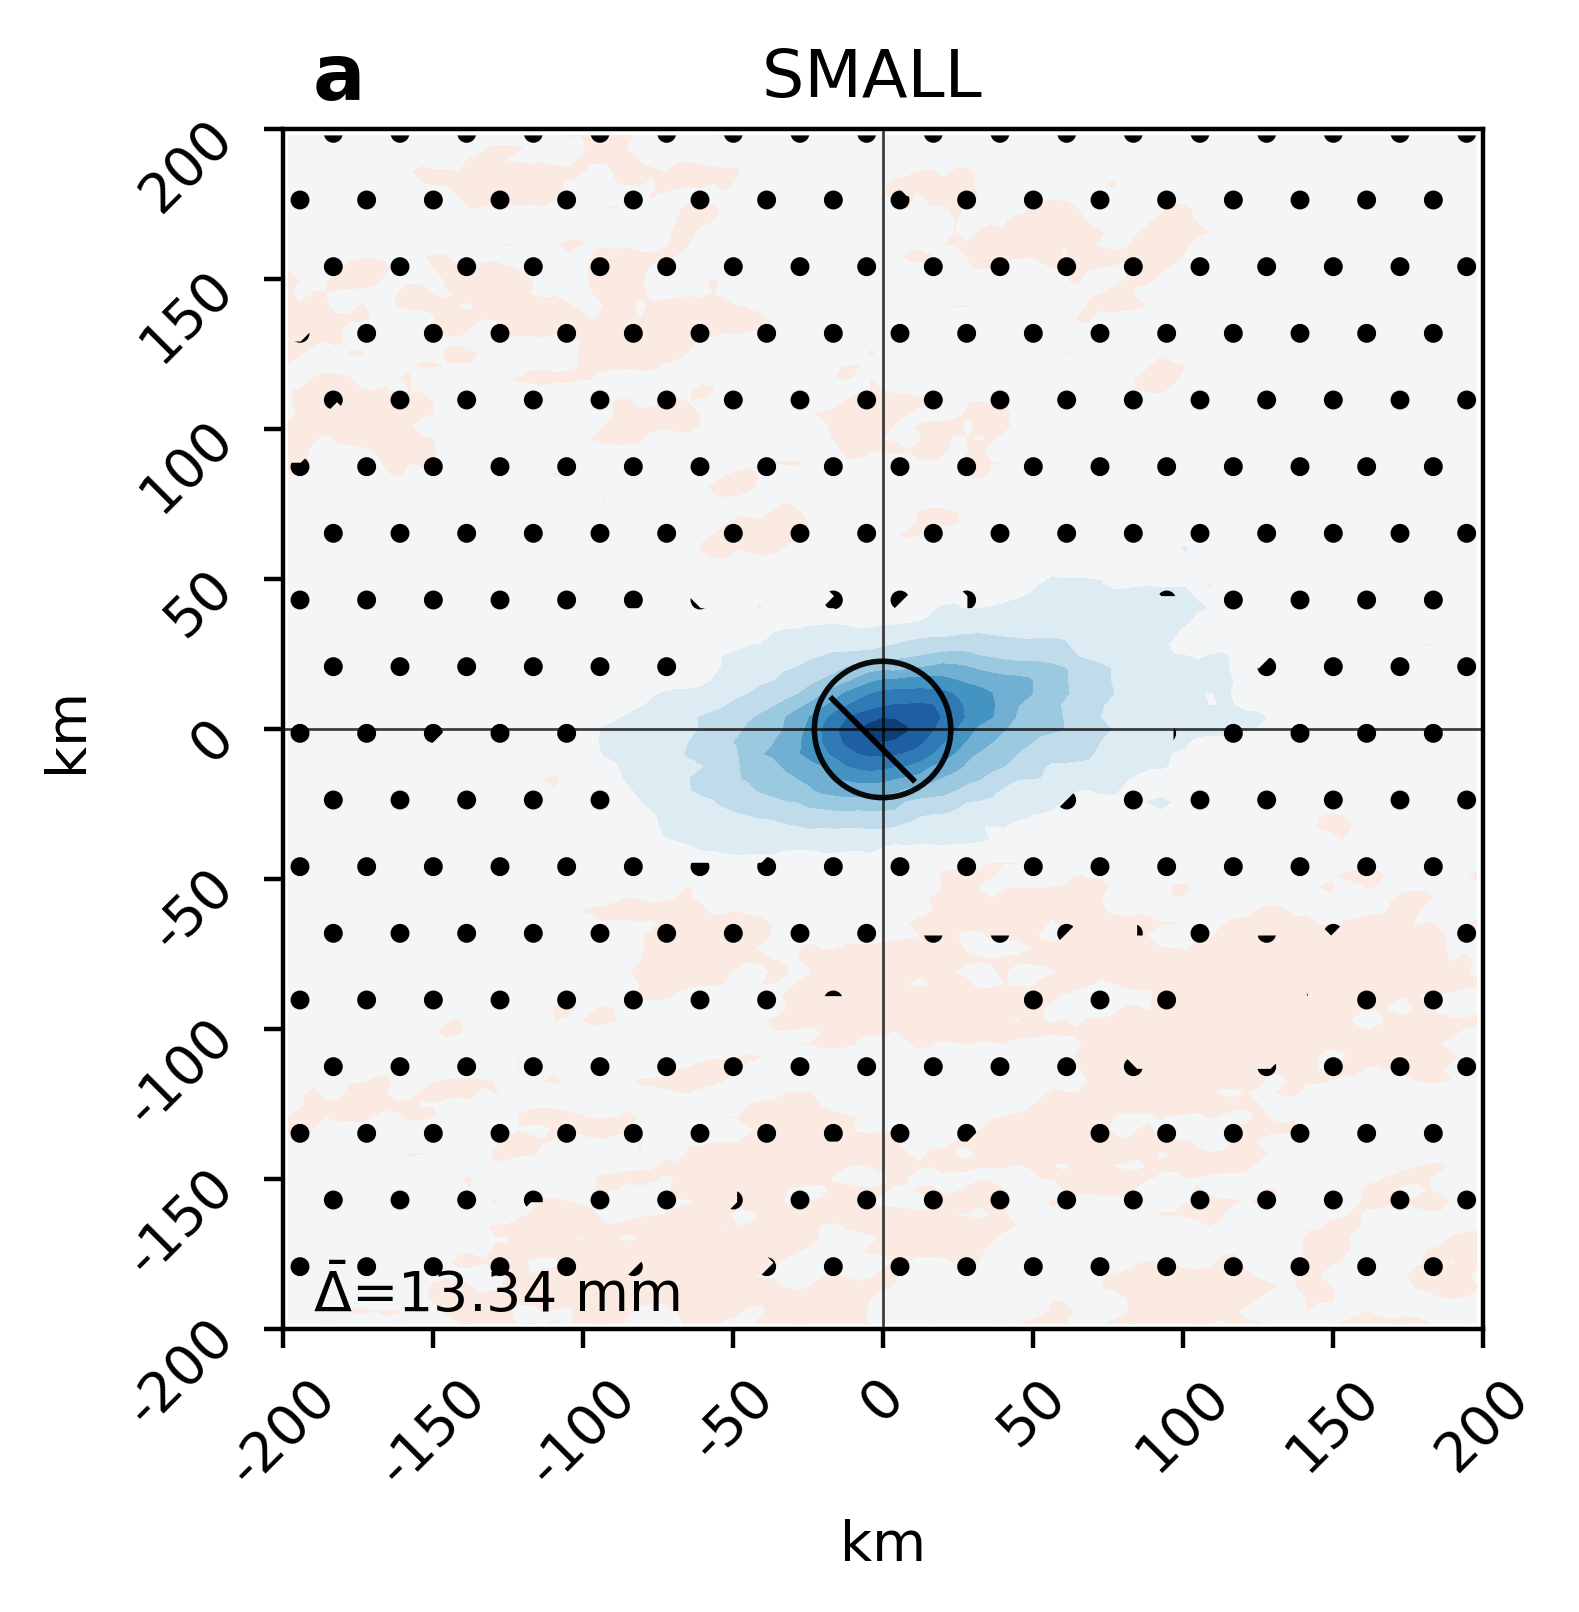

In [13]:
#~ Plot

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor='k', linewidth=1, linestyle='-', alpha=0.95)

anomin = anolims_SM_contrast[var][0]
anomax = anolims_SM_contrast[var][1]

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / res
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / res

cmap_ano = 'RdBu'

hatchstyle = {'small': '\\', 'large': "/"}

bounds = np.linspace(anomin, anomax, 11)
norm = MidpointNormalize(vmin=anomin, vmax=anomax, midpoint=0)

fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)

p_ano = ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap_ano)

ax_ano.contourf(xs, ys, pvalues_, hatches=['.'], colors='none')
ax_ano.contourf(xs, ys, val_disc[0], hatches=hatchstyle[size], colors='none', alpha=0.)

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)
ax_ano.text(0.025, 0.015, '$\\bar{\Delta}$=%.2f %s'% (diff_mean, unit), transform=ax_ano.transAxes)

ax_ano.add_patch(circle_ano)

ax_ano.axhline((ys[-1]-ys[0])/2+ys[0], 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline((xs[-1]-xs[0])/2+xs[0], 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_title('%s '%size.upper())  # (%i km), length)
ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)

fig_ano.set_size_inches(4., 4.)

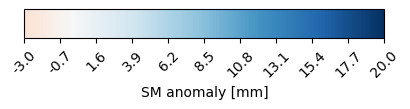

In [8]:
fig_cb_ano, ax_cb_ano = plt.subplots(figsize=(4.5, 1.15))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.65, top=0.9)

cbtks = bounds
cblbs = [str(round(b,2)) for b in bounds]

cb_ano = fig_cb_ano.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_ano), cax=ax_cb_ano, orientation='horizontal', label='%s anomaly [%s]'% (var, unit), shrink=0.95, pad=0.15)
cb_ano.set_ticks(cbtks)
cb_ano.set_ticklabels(cblbs)
cb_ano.ax.tick_params(labelrotation=45.)